# Generating FE Stiffness and Mass Matrices

<b>Goals</b> Generate 1D stiffness and mass matrix by computing the Jacobian of the residual vector.  

## Import Packages

In [2]:
using ForwardDiff
using QuadGK
using StaticArrays 
using LinearAlgebra
using BenchmarkTools
using Plots

## Introduction 
More later. 

### To Do 
1. check type-stability of use of quadgk;
2. check type-stability of use of forward.diff (need to preallocate the memory);
3. check type-stability of combined use of quadgk and forward.diff; 

## Section 1: Generating 1D Shape Functions and First Derivative

In [55]:
# generate basis function centered on node i 
function basisfct(x, xmesh, i)
    Np1 = length(xmesh)
    left = 0.
    right = 0.  
    if (i==1)
        right_domain = (x>=xmesh[i])*(x<=xmesh[i+1])
        right_value = (xmesh[i+1]-x)/(xmesh[i+1]-xmesh[i])
        right = right_value*right_domain        
    end 
    if ((i>1)&&(i<Np1))
        left_domain = (x>=xmesh[i-1])*(x<=xmesh[i])
        left_value = (x-xmesh[i-1])/(xmesh[i]-xmesh[i-1])
        left = left_value*left_domain        
        right_domain = (x>xmesh[i])*(x<=xmesh[i+1])
        right_value = (xmesh[i+1]-x)/(xmesh[i+1]-xmesh[i])
        right = right_value*right_domain        
    end 
    if (i==Np1)
        left_domain = (x>=xmesh[i-1])*(x<=xmesh[i])
        left_value = (x-xmesh[i-1])/(xmesh[i]-xmesh[i-1])
        left = left_value*left_domain
    end 
    result = left+right
    return result 
end

function dbasisfct(x, xmesh, i)
    Np1 = length(xmesh)
    left = 0.
    right = 0.  
    if (i==1)
        right_domain = (x>xmesh[i])*(x<xmesh[i+1])
        right_value = -1/(xmesh[i+1]-xmesh[i])
        right = right_value*right_domain        
    end 
    if ((i>1)&&(i<Np1))
        left_domain = (x>xmesh[i-1])*(x<xmesh[i])
        left_value = 1/(xmesh[i]-xmesh[i-1])
        left = left_value*left_domain        
        right_domain = (x>xmesh[i])*(x<xmesh[i+1])
        right_value = -1/(xmesh[i+1]-xmesh[i])
        right = right_value*right_domain        
    end 
    if (i==Np1)
        left_domain = (x>xmesh[i-1])*(x<xmesh[i])
        left_value = 1/(xmesh[i]-xmesh[i-1])
        left = left_value*left_domain
    end 
    result = left+right
    return result 
end

dbasisfct (generic function with 1 method)

## Section 2: Generating 1D Mesh and Plotting the Basis Functions  
Observe the use of the function Ref to broadcast over the first argument. 

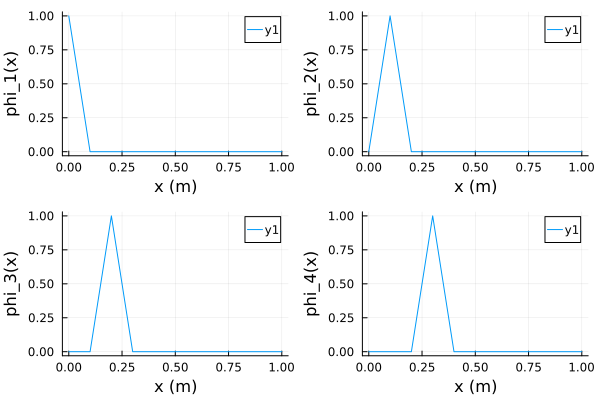

In [56]:
# generate the mesh  with N elements (intervals) and N+1 nodes
N = 10; h = 1/N; Np1 = N+1; 
xmesh = Vector(0:h:1)
xsampled = Vector(0:h/10:1)

p1 = plot(xsampled, basisfct.(xsampled, Ref(xmesh), 1),xaxis="x (m)",yaxis="phi_1(x)")
p2 = plot(xsampled, basisfct.(xsampled, Ref(xmesh), 2),xaxis="x (m)",yaxis="phi_2(x)")
p3 = plot(xsampled, basisfct.(xsampled, Ref(xmesh), 3),xaxis="x (m)",yaxis="phi_3(x)")
p4 = plot(xsampled, basisfct.(xsampled, Ref(xmesh), 4),xaxis="x (m)",yaxis="phi_4(x)")
plot(p1,p2,p3,p4, layout=(2,2))

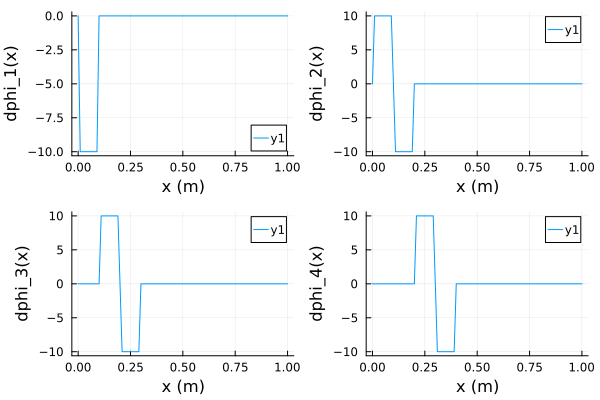

In [57]:
if (true)
  p5 = plot(xsampled, dbasisfct.(xsampled, Ref(xmesh), 1),xaxis="x (m)",yaxis="dphi_1(x)")
  p6 = plot(xsampled, dbasisfct.(xsampled, Ref(xmesh), 2),xaxis="x (m)",yaxis="dphi_2(x)")
  p7 = plot(xsampled, dbasisfct.(xsampled, Ref(xmesh), 3),xaxis="x (m)",yaxis="dphi_3(x)")
  p8 = plot(xsampled, dbasisfct.(xsampled, Ref(xmesh), 4),xaxis="x (m)",yaxis="dphi_4(x)")
  plot(p5,p6,p7,p8, layout=(2,2))
end     

### Test Division on Unit of Basis Functions 

In [58]:
sumbasisfct(x, xmesh) = sum([basisfct(x, xmesh, i) for i=1:Np1]) 
sumbasisfct.(xsampled, Ref(xmesh))

101-element Vector{Float64}:
 1.0
 1.0
 0.9999999999999999
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

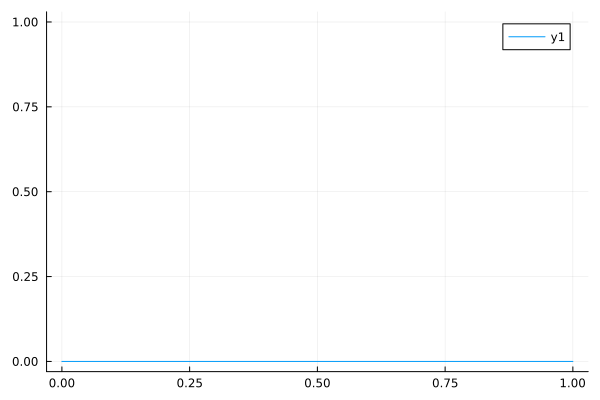

In [59]:
sumbasisfct(x, xmesh) = sum([dbasisfct(x, xmesh, i) for i=1:Np1]) 
plot(xsampled, sumbasisfct.(xsampled, Ref(xmesh)))

## Section 3: Expand Discrete Solution in Basis of Shape Functions    

In [60]:
function uh(x,c,xmesh)
    Np1 = length(xmesh)
    result = 0. 
    for i=1:Np1 
        result += c[i]*basisfct(x,xmesh,i)
    end 
    return result  
end

function duh(x,c,xmesh)
    Np1 = length(xmesh)
    result = 0. 
    for i=1:Np1 
        result += c[i]*dbasisfct(x,xmesh,i)
    end 
    return result  
end

duh (generic function with 1 method)

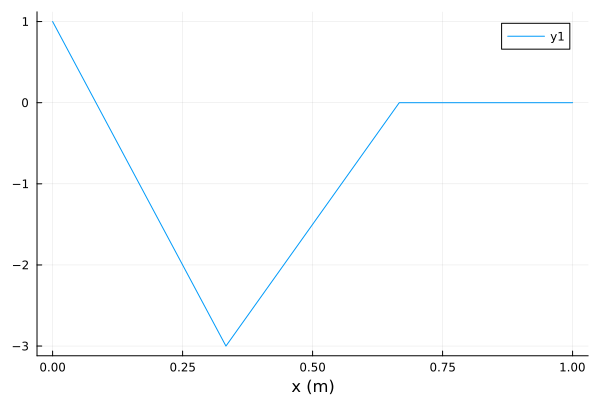

In [61]:
# generate the mesh  with N elements (intervals) and N+1 nodes
N = 3; h = 1/N; Np1 = N+1; 
xmesh = Vector(0:h:1)

# set expansion coefficients 
cvec = zeros(size(xmesh)) 
cvec[1] = 1; cvec[2] = -3 
plot(xmesh, uh.(xmesh,Ref(cvec),Ref(xmesh)),xaxis="x (m)")

## Section 4: Construct Residual Vector via Integration over Support of Basis Function 
After integration over x, the Np1 residual vector is a function of Np1 expansion coefficients.  

In [62]:
# generate the mesh  with N elements (intervals) and N+1 nodes
N = 10; h = 1/N; Np1 = N+1; 
xmesh = Vector(0:h:1)

11-element Vector{Float64}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0

In [63]:
resdens = (x,cvec,xmesh) -> duh(x,cvec,xmesh)*dbasisfct(x,xmesh,1)
result = (cvec,xmesh) -> quadgk(x -> resdens(x,cvec,xmesh), xmesh[1], xmesh[2])[1]
cvec = ones(size(xmesh))
#result(cvec,xmesh)
plot(xmesh,resdens.(xmesh,Ref(cvec),Ref(xmesh)))
h = cvec->result(cvec,xmesh)
ForwardDiff.gradient(h, cvec)

11-element Vector{Float64}:
  10.0
 -10.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0

In [64]:
?quadgk

search: quadgk quadgk! QuadGK quadgk_print quadgk_count



```
quadgk(f, a,b,c...; rtol=sqrt(eps), atol=0, maxevals=10^7, order=7, norm=norm, segbuf=nothing)
```

Numerically integrate the function `f(x)` from `a` to `b`, and optionally over additional intervals `b` to `c` and so on. Keyword options include a relative error tolerance `rtol` (if `atol==0`, defaults to `sqrt(eps)` in the precision of the endpoints), an absolute error tolerance `atol` (defaults to 0), a maximum number of function evaluations `maxevals` (defaults to `10^7`), and the `order` of the integration rule (defaults to 7).

Returns a pair `(I,E)` of the estimated integral `I` and an estimated upper bound on the absolute error `E`. If `maxevals` is not exceeded then `E <= max(atol, rtol*norm(I))` will hold. (Note that it is useful to specify a positive `atol` in cases where `norm(I)` may be zero.)

The endpoints `a` et cetera can also be complex (in which case the integral is performed over straight-line segments in the complex plane). If the endpoints are `BigFloat`, then the integration will be performed in `BigFloat` precision as well.

!!! note
    It is advisable to increase the integration `order` in rough proportion to the precision, for smooth integrands.


More generally, the precision is set by the precision of the integration endpoints (promoted to floating-point types).

The integrand `f(x)` can return any numeric scalar, vector, or matrix type, or in fact any type supporting `+`, `-`, multiplication by real values, and a `norm` (i.e., any normed vector space). Alternatively, a different norm can be specified by passing a `norm`-like function as the `norm` keyword argument (which defaults to `norm`).

!!! note
    Only one-dimensional integrals are provided by this function. For multi-dimensional integration (cubature), there are many different algorithms (often much better than simple nested 1d integrals) and the optimal choice tends to be very problem-dependent. See the Julia external-package listing for available algorithms for multidimensional integration or other specialized tasks (such as integrals of highly oscillatory or singular functions).


The algorithm is an adaptive Gauss-Kronrod integration technique: the integral in each interval is estimated using a Kronrod rule (`2*order+1` points) and the error is estimated using an embedded Gauss rule (`order` points). The interval with the largest error is then subdivided into two intervals and the process is repeated until the desired error tolerance is achieved.

These quadrature rules work best for smooth functions within each interval, so if your function has a known discontinuity or other singularity, it is best to subdivide your interval to put the singularity at an endpoint. For example, if `f` has a discontinuity at `x=0.7` and you want to integrate from 0 to 1, you should use `quadgk(f, 0,0.7,1)` to subdivide the interval at the point of discontinuity. The integrand is never evaluated exactly at the endpoints of the intervals, so it is possible to integrate functions that diverge at the endpoints as long as the singularity is integrable (for example, a `log(x)` or `1/sqrt(x)` singularity).

For real-valued endpoints, the starting and/or ending points may be infinite. (A coordinate transformation is performed internally to map the infinite interval to a finite one.)

In normal usage, `quadgk(...)` will allocate a buffer for segments. You can instead pass a preallocated buffer allocated using `alloc_segbuf(...)` as the `segbuf` argument. This buffer can be used across multiple calls to avoid repeated allocation.

---

```
quadgk(f::BatchIntegrand, a,b,c...; kws...)
```

Like [`quadgk`](@ref), but batches evaluation points for an in-place integrand to evaluate simultaneously. In particular, there are two differences from `quadgk`

1. The function `f.f!` should be of the form `f!(y, x) = y .= f.(x)`.  That is, it writes the return values of the integand `f(x)` in-place into its first argument `y`. (The return value of `f!` is ignored.) See [`BatchIntegrand`](@ref) for how to define the integrand.
2. `f.max_batch` changes how the adaptive refinement is done by batching multiple segments together. Choosing `max_batch<=4*order+2` will reproduce the result of non-batched `quadgk`, however if `max_batch=n*(4*order+2)` up to `2n` Kronrod rules will be evaluated together, which can produce slightly different results and sometimes require more integrand evaluations when using relative tolerances.


In [65]:
function resarray(cvec,xmesh)
    Np1 = length(xmesh)
    residual = zeros(eltype(cvec),Np1)
    
    resdens = Array{Function}(undef, Np1)
    for i=1:Np1 
        resdens[i] = (x,cvec,xmesh) -> duh(x,cvec,xmesh)*dbasisfct(x,xmesh,i)
    end     

    residual[1] = quadgk(x -> resdens[1](x,cvec,xmesh), xmesh[1], xmesh[2])[1]
    
    for i=2:N 
        residual[i] = quadgk(x -> resdens[i](x,cvec,xmesh), xmesh[i-1], xmesh[i+1])[1]
    end 
    
    residual[end] = quadgk(x -> resdens[end](x,cvec,xmesh), xmesh[end-1], xmesh[end])[1]  
    
    return residual
end 

resarray (generic function with 1 method)

In [66]:
cvec = 2*ones(size(xmesh))
resarray(cvec,xmesh)

11-element Vector{Float64}:
 -0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [67]:
cvec = ones(size(xmesh))
h = cvec->resarray(cvec,xmesh)
A = ForwardDiff.jacobian(h,cvec)

11×11 Matrix{Float64}:
 10.0      -10.0      -0.0      -0.0      …  -0.0       -0.0      -0.0
 -8.95259   17.9052   -8.95259   0.0          0.0        0.0       0.0
  0.0       -8.95259  17.9052   -8.95259      0.0        0.0       0.0
  0.0        0.0      -8.95259  20.0          0.0        0.0       0.0
  0.0        0.0       0.0      -8.95259      0.0        0.0       0.0
  0.0        0.0       0.0       0.0      …   0.0        0.0       0.0
  0.0        0.0       0.0       0.0          0.0        0.0       0.0
  0.0        0.0       0.0       0.0         -8.95259    0.0       0.0
  0.0        0.0       0.0       0.0         17.9052    -8.95259   0.0
  0.0        0.0       0.0       0.0         -8.95259   17.9052   -8.95259
  0.0        0.0       0.0       0.0      …   0.0      -10.0      10.0

In [68]:
A[6,:]

11-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
 -8.952589294576363
 17.905178589152726
 -8.952589294576363
  0.0
  0.0
  0.0
  0.0

## Section 5: MWE  

In [12]:
function fooworks(cvec,xmesh)
    residual = cvec 
    return residual
end 

fooworks (generic function with 1 method)

In [13]:
#function foofails(cvec,xmesh)
function foofails(cvec)
    N = length(cvec)
    residual = zeros(length(cvec)) 
    for i=1:N 
        residual[i] = cvec[i] 
    end 

    return residual
end 

foofails (generic function with 1 method)

In [14]:
# generate the mesh  with N elements (intervals) and N+1 nodes
N = 10; h = 1/N; Np1 = N+1; 
xmesh = Vector(0:h:1)

11-element Vector{Float64}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0

In [15]:
cvec = ones(size(xmesh))
h = cvec->fooworks(cvec,xmesh);
#hh(cvec) = foofails(cvec,xmesh)
ForwardDiff.jacobian(foofails,cvec)

LoadError: MethodError: no method matching Float64(::ForwardDiff.Dual{ForwardDiff.Tag{typeof(foofails), Float64}, Float64, 11})
[0mClosest candidates are:
[0m  (::Type{T})(::Real, [91m::RoundingMode[39m) where T<:AbstractFloat at rounding.jl:200
[0m  (::Type{T})(::T) where T<:Number at boot.jl:772
[0m  (::Type{T})([91m::AbstractChar[39m) where T<:Union{AbstractChar, Number} at char.jl:50
[0m  ...